In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Import the files

In [2]:
# Import the file with results:

# results of experiments with CroSloEngual BERT:
with open("results-CroSloEngualBERT/main-classification-results-crosloengualbert3runs.json") as results_file:
    results = json.load(results_file)

In [3]:
# Import one training file to get the labels.
train_df = pd.read_csv("G:\My Drive\GitHub\Cross-Lingual-and-Cross-Dataset-Experiments-with-Genre-Datasets\data\SI_GINCO_train.csv")
train_df.head()

,text,labels
0,PES - BITJE ZA OSAMLJENE? <p/> Življenje z živ...,Opinion/Argumentation
1,Predelne stene <p/> Pogosto se zgodi da pri gr...,Promotion
2,V Izoli se je končal 9. mednarodni turnir v go...,News
3,Okvirji za vaše plakate <p/> Pri naročilu okvi...,Instruction
4,"Bojijo se lakote <p/> Sto ekip, 30 evropskih m...",News


In [4]:
LABELS = list(train_df.labels.unique())
LABELS

['Opinion/Argumentation',
 'Promotion',
 'News',
 'Instruction',
 'Information/Explanation',
 'Legal/Regulation',
 'Review',
 'Research Article',
 'Forum',
 'Recipe',
 'Prose',
 'Interview']

In [5]:
# Calculate scores per labels and add this information to results
for instance in results:
    y_true = instance["y_true"]
    y_pred = instance["y_pred"]

    score_per_label = list(f1_score(y_true, y_pred, labels=LABELS, average=None))

    dict_score_per_label = {}

    for index in range(len(LABELS)):
        dict_score_per_label[LABELS[index]] = score_per_label[index]

    instance["scores_per_labels"] = dict_score_per_label

In [6]:
# Add to the results one column where trained_on and tested_on are joined
for instance in results:
    current_trained_on = instance["trained_on"]
    current_tested_on = instance["tested_on"]
    current_setup = f"{current_trained_on},{current_tested_on}"
    instance["setup"] = current_setup

In [7]:
# Inspect the results as a dataframe
results_df = pd.DataFrame(results)
results_df.head()

,trained_on,tested_on,microF1,macroF1,y_true,y_pred,scores_per_labels,setup
0,SL-GINCO,SL-GINCO,0.722222,0.503678,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Promotion, News, Instruction...","{'Opinion/Argumentation': 0.6511627906976744, ...","SL-GINCO,SL-GINCO"
1,SL-GINCO,CORE,0.558225,0.416810,"[News, News, News, News, Information/Explanati...","[News, Opinion/Argumentation, News, Opinion/Ar...","{'Opinion/Argumentation': 0.5649274225186347, ...","SL-GINCO,CORE"
2,MT-GINCO,MT-GINCO,0.716049,0.535164,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Promotion, News, Instruction...","{'Opinion/Argumentation': 0.5, 'Promotion': 0....","MT-GINCO,MT-GINCO"
3,MT-GINCO,CORE,0.597288,0.419149,"[News, News, News, News, Information/Explanati...","[News, Promotion, News, News, Opinion/Argument...","{'Opinion/Argumentation': 0.5732170802593338, ...","MT-GINCO,CORE"
4,CORE,SL-GINCO,0.543210,0.477446,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Information/Explanation, New...","{'Opinion/Argumentation': 0.35714285714285715,...","CORE,SL-GINCO"


In [9]:
results_df.describe()

,microF1,macroF1
count,22.000000,22.000000
mean,0.652722,0.526179
std,0.084354,0.108349
min,0.524469,0.359926
25%,0.577609,0.421954
50%,0.635802,0.535156
75%,0.731481,0.573272
max,0.764446,0.709241


In [8]:
setups = list(results_df.setup.unique())
print(setups)

['SL-GINCO,SL-GINCO', 'SL-GINCO,CORE', 'MT-GINCO,MT-GINCO', 'MT-GINCO,CORE', 'CORE,SL-GINCO', 'CORE,MT-GINCO', 'CORE,CORE']


In [10]:
# Create a dictionary of results, averaged over all the runs. In the dictionary, setups are keys and its values are dictionaries that contain average micro f1, micro f1 std, average macro f1, macro f1 std, average f1s per labels and std for results for labels.
average_results = {}

for setup in setups:
    # Add new key if it is not yet in the dictionary
    if setup not in average_results:
        average_results[setup] = {"microF1": 0, "micro_std": 0, "macroF1": 0, "macro_std": 0, "labels_f1": [], "labels_std": []}
    
    average_label_score = {'Opinion/Argumentation': [], 'Promotion': [], 'News': [], 'Instruction': [], 'Information/Explanation': [], 'Legal/Regulation': [], 'Review': [], 'Research Article': [], 'Forum': [], 'Recipe': [], 'Prose': [], 'Interview': []}

    average_micro = []
    average_macro = []

    for element in results:
        if element["setup"] == setup:
            # Add micro and macro scores to the list of micro and macro scores for this setup
            average_micro.append(element["microF1"])
            average_macro.append(element["macroF1"])
            # Add label scores to the dictionary of setup label scores
            for key in list(average_label_score.keys()):
                average_label_score[key].append(element["scores_per_labels"][key])

    # Calculate average micros and macros and std based on the lists of all scores
    average_results[setup]["microF1"] = np.array(average_micro).mean()
    average_results[setup]["micro_std"] = np.array(average_micro).std()
    average_results[setup]["macroF1"] = np.array(average_macro).mean()
    average_results[setup]["macro_std"] = np.array(average_macro).std()
    average_results[setup]["label_scores"] = average_label_score

    # Calculate average scores for each label based on the average_label_score list
    #average_results[setup]["labels_f1"] = [np.array(average_label_score[key]).mean() for key in list(average_label_score.keys())]
    #average_results[setup]["labels_std"] = [np.array(average_label_score[key]).std() for key in list(average_label_score.keys())]

    average_results[setup]["labels_f1"] = {'Opinion/Argumentation': [], 'Promotion': [], 'News': [], 'Instruction': [], 'Information/Explanation': [], 'Legal/Regulation': [], 'Review': [], 'Research Article': [], 'Forum': [], 'Recipe': [], 'Prose': [], 'Interview': []}
    for key in list(average_results[setup]["labels_f1"].keys()):
        average_results[setup]["labels_f1"][key] = np.array(average_label_score[key]).mean()
    average_results[setup]["labels_std"] = {'Opinion/Argumentation': [], 'Promotion': [], 'News': [], 'Instruction': [], 'Information/Explanation': [], 'Legal/Regulation': [], 'Review': [], 'Research Article': [], 'Forum': [], 'Recipe': [], 'Prose': [], 'Interview': []}
    for key in list(average_results[setup]["labels_std"].keys()):
        average_results[setup]["labels_std"][key] = np.array(average_label_score[key]).std()

In [32]:
print(average_results["MT-GINCO,MT-GINCO"])

{'microF1': 0.7139917695473251, 'micro_std': 0.0029099044493273167, 'macroF1': 0.5007824961741022, 'macro_std': 0.04979663776020273, 'labels_f1': {'Opinion/Argumentation': 0.5861952861952862, 'Promotion': 0.7841598953955357, 'News': 0.8000352360817476, 'Instruction': 0.6789215686274511, 'Information/Explanation': 0.6204644412191582, 'Legal/Regulation': 0.7000000000000001, 'Review': 0.35555555555555557, 'Research Article': 0.0, 'Forum': 0.8173913043478261, 'Recipe': 0.3333333333333333, 'Prose': 0.0, 'Interview': 0.3333333333333333}, 'labels_std': {'Opinion/Argumentation': 0.061222084360657646, 'Promotion': 0.02111966771049684, 'News': 0.0100314593696171, 'Instruction': 0.038128306828686405, 'Information/Explanation': 0.023604435366169237, 'Legal/Regulation': 0.14142135623730953, 'Review': 0.03142696805273547, 'Research Article': 0.0, 'Forum': 0.037569511295118034, 'Recipe': 0.4714045207910317, 'Prose': 0.0, 'Interview': 0.4714045207910317}, 'label_scores': {'Opinion/Argumentation': [0.5

## Print Latex Tables

In [13]:
# Print out a latex table with average micro and macro scores and stds
# Get a Latex table with mean and std results

print("\\hline")
print("\\textbf{Setup (Trained on, Tested on)} & \\textbf{Micro F1} & \\textbf{Macro F1}\\\\")
print("\\hline\\hline")

for element in list(average_results.keys()):
    print(f"{element} & {round(average_results[element]['microF1'],3)} $\pm$ {round(average_results[element]['micro_std'],2)} & {round(average_results[element]['macroF1'],3)} $\pm$ {round(average_results[element]['macro_std'],2)} \\\\")

\hline
\textbf{Setup (Trained on, Tested on)} & \textbf{Micro F1} & \textbf{Macro F1}\\
\hline\hline
SL-GINCO,SL-GINCO & 0.738 $\pm$ 0.01 & 0.599 $\pm$ 0.06 \\
SL-GINCO,CORE & 0.547 $\pm$ 0.02 & 0.391 $\pm$ 0.02 \\
MT-GINCO,MT-GINCO & 0.714 $\pm$ 0.0 & 0.501 $\pm$ 0.05 \\
MT-GINCO,CORE & 0.585 $\pm$ 0.01 & 0.409 $\pm$ 0.01 \\
CORE,SL-GINCO & 0.566 $\pm$ 0.02 & 0.51 $\pm$ 0.03 \\
CORE,MT-GINCO & 0.63 $\pm$ 0.01 & 0.543 $\pm$ 0.01 \\
CORE,CORE & 0.761 $\pm$ 0.0 & 0.706 $\pm$ 0.0 \\


## Print Markdown Tables

In [14]:
print("|Setup (Trained on, Tested on)|Micro F1|Macro F1|")
print("|:----|----|----:|")

for element in list(average_results.keys()):
    print(f"|{element} | {round(average_results[element]['microF1'],3)} +/- {round(average_results[element]['micro_std'],2)} | {round(average_results[element]['macroF1'],3)} +/- {round(average_results[element]['macro_std'],2)} |")

|Setup (Trained on, Tested on)|Micro F1|Macro F1|
|:----|----|----:|
|SL-GINCO,SL-GINCO | 0.738 +/- 0.01 | 0.599 +/- 0.06 |
|SL-GINCO,CORE | 0.547 +/- 0.02 | 0.391 +/- 0.02 |
|MT-GINCO,MT-GINCO | 0.714 +/- 0.0 | 0.501 +/- 0.05 |
|MT-GINCO,CORE | 0.585 +/- 0.01 | 0.409 +/- 0.01 |
|CORE,SL-GINCO | 0.566 +/- 0.02 | 0.51 +/- 0.03 |
|CORE,MT-GINCO | 0.63 +/- 0.01 | 0.543 +/- 0.01 |
|CORE,CORE | 0.761 +/- 0.0 | 0.706 +/- 0.0 |


## Plot: Macro and micro F1 scores

### All setups

C:\Users\TajaK\AppData\Local\Temp\ipykernel_9800\1089293442.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


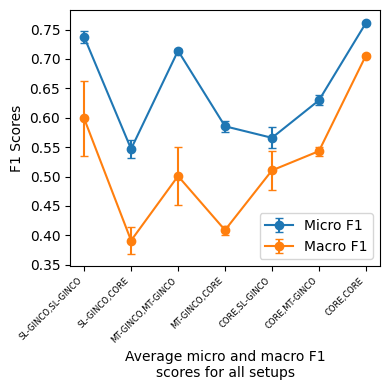

In [11]:
# Plot the differences between the average micro and macro scores for different setups:
average_mi = []
average_mi_std = []
average_ma = []
average_ma_std = []

for setup in setups:
    current_i = setup
    average_mi.append(average_results[current_i]["microF1"])
    average_mi_std.append(average_results[current_i]["micro_std"])
    average_ma.append(average_results[current_i]["macroF1"])
    average_ma_std.append(average_results[current_i]["macro_std"])

fig, ax = plt.subplots(figsize=(4,4), dpi=100)

ax.errorbar(setups, average_mi, yerr=average_mi_std, fmt='-o', label="Micro F1", capsize=3)
ax.errorbar(setups, average_ma, yerr=average_ma_std, fmt='-o', label="Macro F1", capsize=3)

plt.xticks(fontsize=6)
ax.set_xlabel('Setups')
ax.set_ylabel('F1 Scores')
xlabels = setups
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.legend(loc="lower right")
ax.set_xlabel("Average micro and macro F1\nscores for all setups")
fig.tight_layout()
#plt.savefig("results-RoBERTa\RoBERTa-scores-per-setups.png")
plt.show()

### In-dataset experiments

C:\Users\TajaK\AppData\Local\Temp\ipykernel_9800\890438554.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


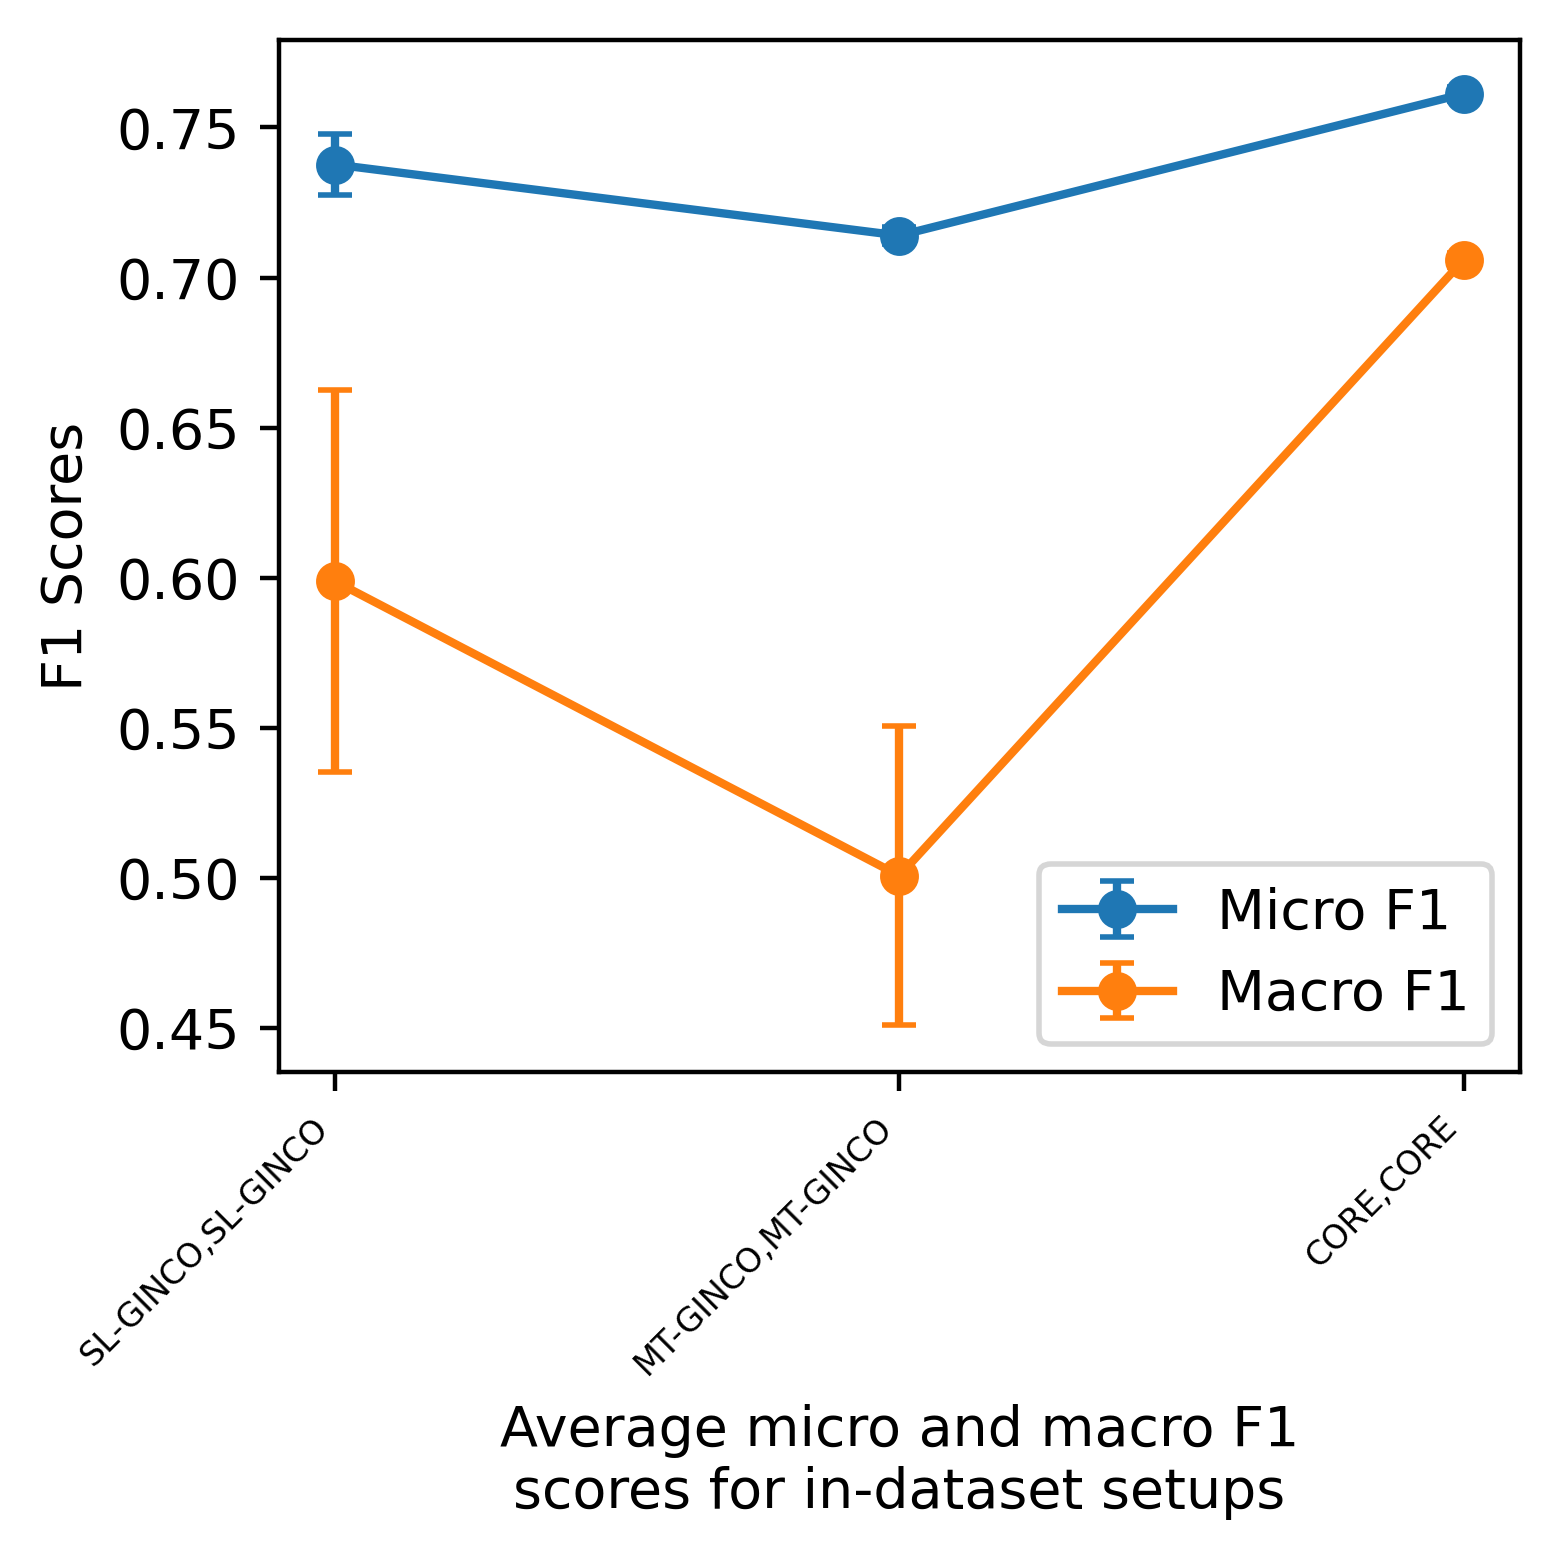

In [12]:
# Plot the figure for in-dataset experiments
# Plot the differences between the average micro and macro scores for different setups:
setup_of_interest = ['SL-GINCO,SL-GINCO', 'MT-GINCO,MT-GINCO', 'CORE,CORE' ]

average_mi = []
average_mi_std = []
average_ma = []
average_ma_std = []

for setup in setup_of_interest:
    current_i = setup
    average_mi.append(average_results[current_i]["microF1"])
    average_mi_std.append(average_results[current_i]["micro_std"])
    average_ma.append(average_results[current_i]["macroF1"])
    average_ma_std.append(average_results[current_i]["macro_std"])

fig, ax = plt.subplots(figsize=(4,4), dpi=400)

ax.errorbar(setup_of_interest, average_mi, yerr=average_mi_std, fmt='-o', label="Micro F1", capsize=3)
ax.errorbar(setup_of_interest, average_ma, yerr=average_ma_std, fmt='-o', label="Macro F1", capsize=3)

plt.xticks(fontsize=6)
ax.set_xlabel('Setups')
ax.set_ylabel('F1 Scores')
xlabels = setup_of_interest
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.legend(loc="lower right")
ax.set_xlabel("Average micro and macro F1\nscores for in-dataset setups")
fig.tight_layout()
#plt.savefig("results-CroSloEngualBERT\CroSloEngualBERT-scores-SI-GINCO-indataset-vs-transfer-to-CORE.png")
plt.show()

### Cross-lingual experiments

C:\Users\TajaK\AppData\Local\Temp\ipykernel_9800\1640720754.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


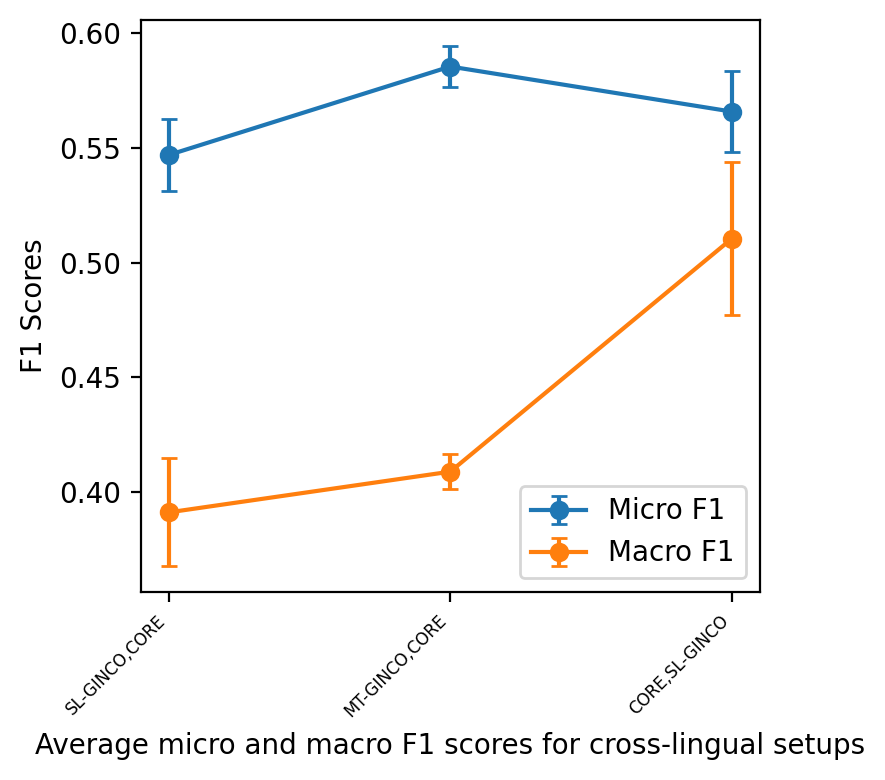

In [13]:
# Plot the figure for cross-lingual experiments
# Plot the differences between the average micro and macro scores for different setups:
setup_of_interest = ['SL-GINCO,CORE', 'MT-GINCO,CORE','CORE,SL-GINCO']

average_mi = []
average_mi_std = []
average_ma = []
average_ma_std = []

for setup in setup_of_interest:
    current_i = setup
    average_mi.append(average_results[current_i]["microF1"])
    average_mi_std.append(average_results[current_i]["micro_std"])
    average_ma.append(average_results[current_i]["macroF1"])
    average_ma_std.append(average_results[current_i]["macro_std"])

fig, ax = plt.subplots(figsize=(4,4), dpi=200)

ax.errorbar(setup_of_interest, average_mi, yerr=average_mi_std, fmt='-o', label="Micro F1", capsize=3)
ax.errorbar(setup_of_interest, average_ma, yerr=average_ma_std, fmt='-o', label="Macro F1", capsize=3)

plt.xticks(fontsize=6)
ax.set_xlabel('Setups')
ax.set_ylabel('F1 Scores')
xlabels = setup_of_interest
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.legend(loc="lower right")
ax.set_xlabel("Average micro and macro F1 scores for cross-lingual setups")
fig.tight_layout()
#plt.savefig("results-CroSloEngualBERT\CroSloEngualBERT-label-scores-SI-GINCO-indataset-vs-transfer-to-CORE.png")
plt.show()

## Plot: Scores per Labels

x_SL_CSE = [0.3191883246100726, 0.7124580930587778, 0.3499582211613528, 0.5560789016045916, 0.34836778324851725, 0.37997054153839555, 0.4027797499357584, 0.46537338339591167, 0.47556310363165394, 0.1862885309558118, 0.05882352941176471, 0.43804565029383724]
yerr_SL_CSE = [0.009268451302862267, 0.013273371185560712, 0.02935124624330425, 0.017227591953430387, 0.08334553617480622, 0.017342311377920024, 0.030264565066782885, 0.030624281598028758, 0.012396070924377549, 0.07701862136316429, 0.0, 0.041301093308675055]
x_CORE_CSE = [0.5809792843691148, 0.7130985480383072, 0.4499202109094333, 0.48441298441298436, 0.8452380952380952, 0.14074074074074075, 0.5777777777777778, 0.0, 0.6666666666666666, 0.8888888888888888, 0.7777777777777777, 0.0]
yerr_CORE_CSE = [0.014009578089188159, 0.02416832176311306, 0.024359770855781174, 0.09020209399081255, 0.0637395968420992, 0.09993138935727437, 0.12570787221094176, 0.0, 0.0, 0.15713484026367724, 0.15713484026367724, 0.0]


C:\Users\TajaK\AppData\Local\Temp\ipykernel_9800\3672695348.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


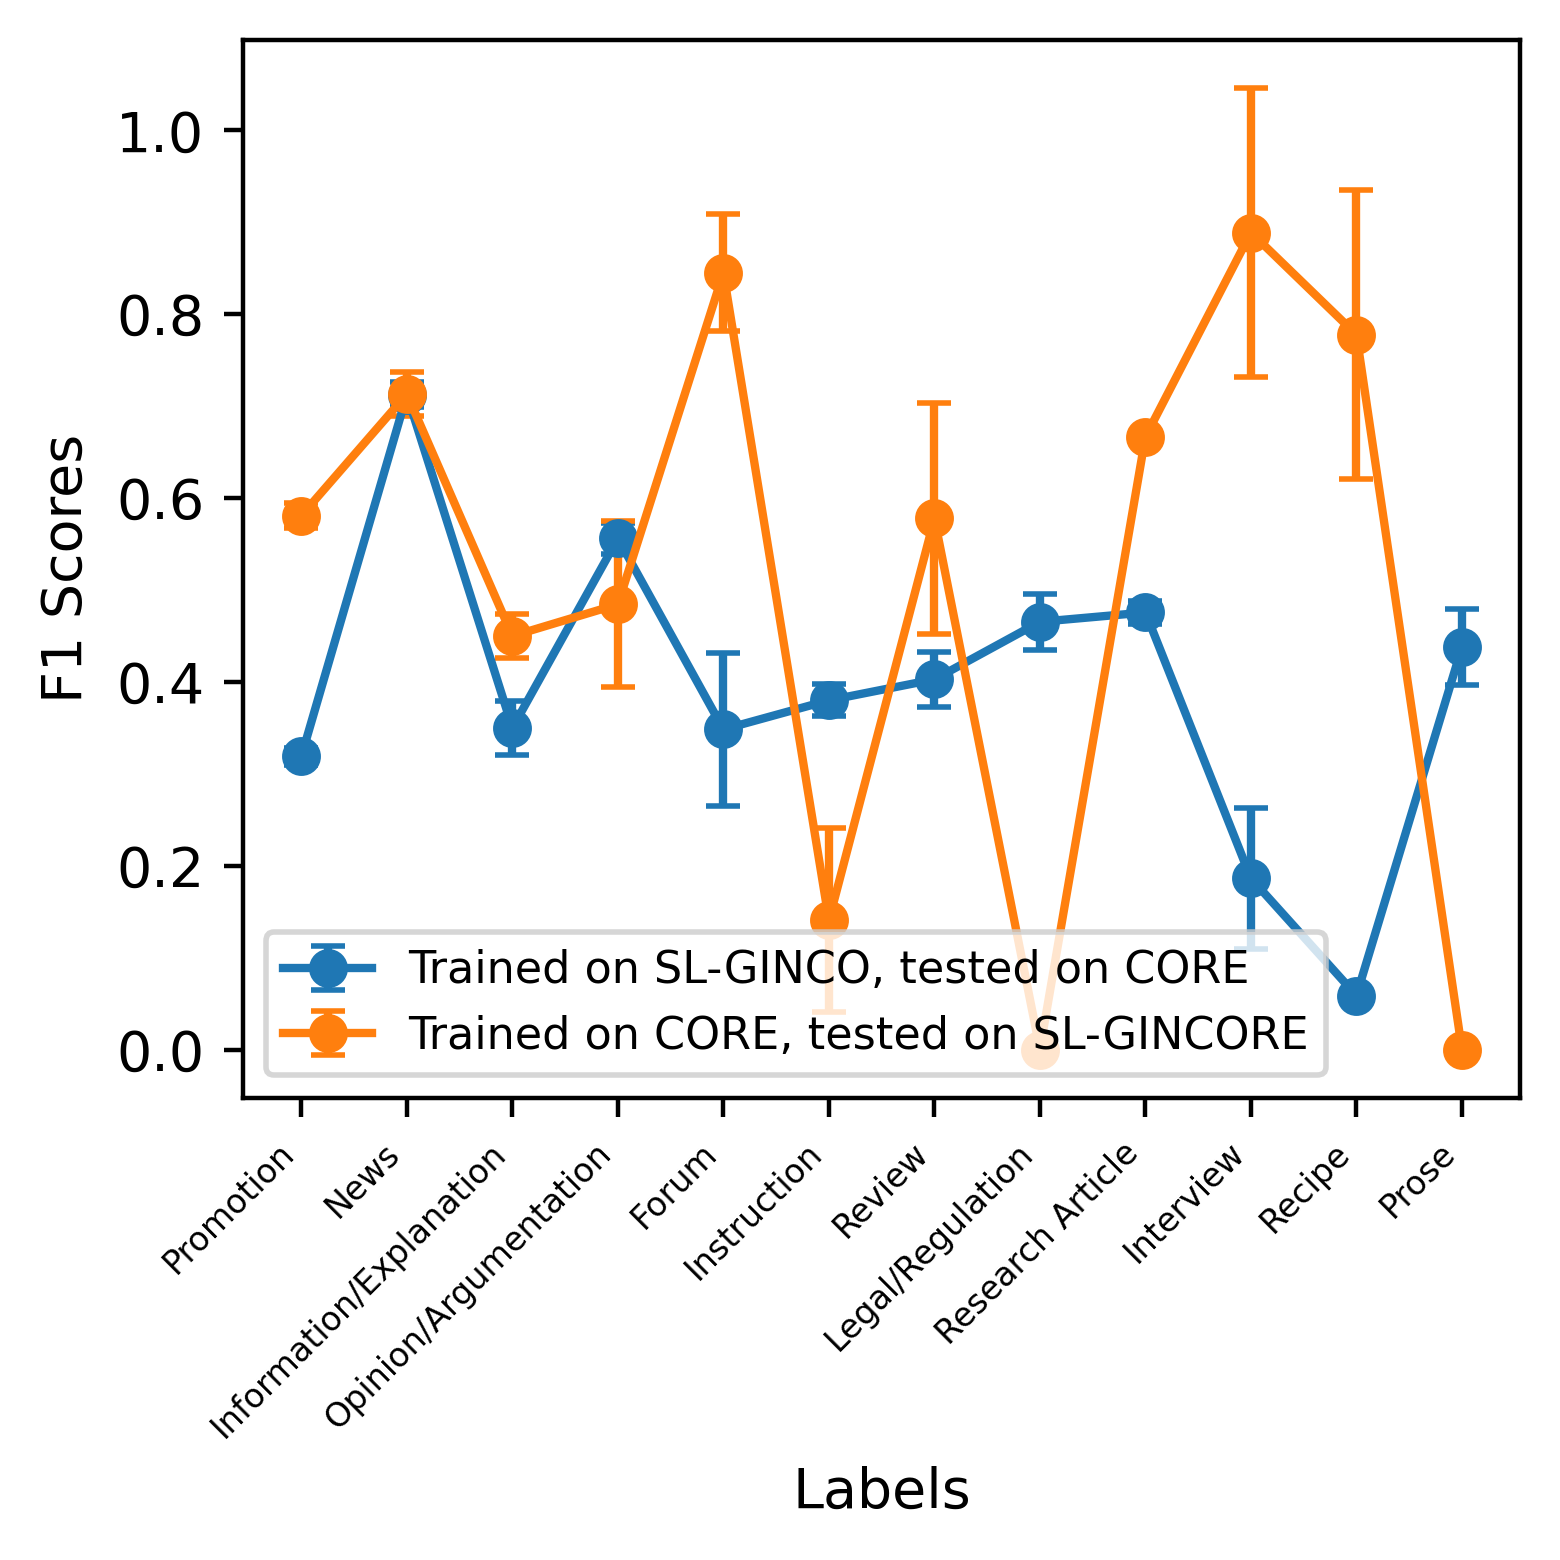

In [18]:
# Plot the differences between the average label scores in different setups:
labels_names = LABELS

#List of label's names based on their frequency in the GINCO corpus:
labels_frequency_list = ["Promotion","News","Information/Explanation","Opinion/Argumentation","Forum","Instruction","Review","Legal/Regulation","Research Article","Interview","Recipe","Prose"]

fig, ax = plt.subplots(figsize=(4,4), dpi=400)
for setup in setups:
    current_i = setup
    current_i_list = current_i.split(",")
    trained_on = current_i_list[0]
    tested_on = current_i_list[1]
    if trained_on in ["SL-GINCO"] and tested_on in ["CORE"]:
        plot_label = "Trained on SL-GINCO, tested on CORE"
        x = []
        for label in labels_frequency_list:
            x.append(average_results[current_i]['labels_f1'][label])
        print(f"x_SL_CSE = {x}")
        yerr = []
        for label in labels_frequency_list:
            yerr.append(average_results[current_i]["labels_std"][label])
        print(f"yerr_SL_CSE = {yerr}")
        ax.errorbar(labels_frequency_list, x, yerr, fmt='-o', label=plot_label, capsize=3)
    elif trained_on in ["CORE"] and tested_on in ["SL-GINCO"]:
        plot_label = f"Trained on CORE, tested on SL-GINCORE"
        x = []
        for label in labels_frequency_list:
            x.append(average_results[current_i]['labels_f1'][label])
        print(f"x_CORE_CSE = {x}")
        yerr = []
        for label in labels_frequency_list:
            yerr.append(average_results[current_i]["labels_std"][label])
        print(f"yerr_CORE_CSE = {yerr}")
        ax.errorbar(labels_frequency_list, x, yerr, fmt='-o', label=plot_label, capsize=3)

plt.xticks(fontsize=6)
ax.set_xlabel('Labels')
ax.set_ylabel('F1 Scores')
xlabels = labels_frequency_list
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.legend(loc="lower left", prop={'size': 8})
#ax.set_xlabel("Difference between labels scores between EN-GINCORE and MT-GINCORE \n(in-dataset experiments with CroSloEngualBERT)")
fig.tight_layout()
#plt.savefig("results-CroSloEngualBERT\label-scores-indataset-CORE-MT-GINCO-CroSloEngualBERT.png")
plt.show()

## Plot: Confusion Matrix

In [76]:
# See which setups you can choose
results_df

,trained_on,tested_on,microF1,macroF1,y_true,y_pred,scores_per_labels,setup
0,SL-GINCO,SL-GINCO,0.722222,0.503678,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Promotion, News, Instruction...","{'Opinion/Argumentation': 0.6511627906976744, ...","SL-GINCO,SL-GINCO"
1,SL-GINCO,CORE,0.558225,0.416810,"[News, News, News, News, Information/Explanati...","[News, Opinion/Argumentation, News, Opinion/Ar...","{'Opinion/Argumentation': 0.5649274225186347, ...","SL-GINCO,CORE"
2,MT-GINCO,MT-GINCO,0.716049,0.535164,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Promotion, News, Instruction...","{'Opinion/Argumentation': 0.5, 'Promotion': 0....","MT-GINCO,MT-GINCO"
3,MT-GINCO,CORE,0.597288,0.419149,"[News, News, News, News, Information/Explanati...","[News, Promotion, News, News, Opinion/Argument...","{'Opinion/Argumentation': 0.5732170802593338, ...","MT-GINCO,CORE"
4,CORE,SL-GINCO,0.543210,0.477446,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Information/Explanation, New...","{'Opinion/Argumentation': 0.35714285714285715,...","CORE,SL-GINCO"
5,CORE,MT-GINCO,0.635802,0.553304,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Information/Explanation, New...","{'Opinion/Argumentation': 0.5294117647058824, ...","CORE,MT-GINCO"
6,CORE,CORE,0.759434,0.703473,"[News, News, News, News, Information/Explanati...","[News, News, News, News, Opinion/Argumentation...","{'Opinion/Argumentation': 0.7211728221031858, ...","CORE,CORE"
7,SL-GINCO,SL-GINCO,0.746914,0.664956,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Promotion, News, Promotion, ...","{'Opinion/Argumentation': 0.631578947368421, '...","SL-GINCO,SL-GINCO"
8,SL-GINCO,CORE,0.558078,0.396488,"[News, News, News, News, Information/Explanati...","[News, Promotion, News, News, Opinion/Argument...","{'Opinion/Argumentation': 0.5713132943312488, ...","SL-GINCO,CORE"
9,MT-GINCO,MT-GINCO,0.716049,0.536818,"[Promotion, News, Promotion, News, Instruction...","[Promotion, News, Information/Explanation, New...","{'Opinion/Argumentation': 0.6222222222222223, ...","MT-GINCO,MT-GINCO"


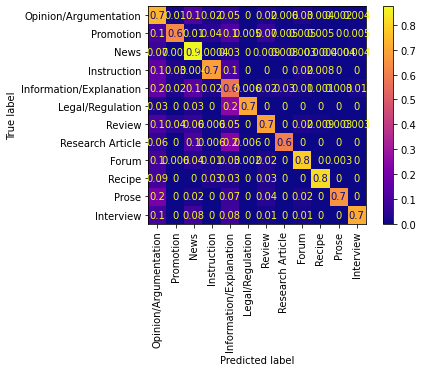

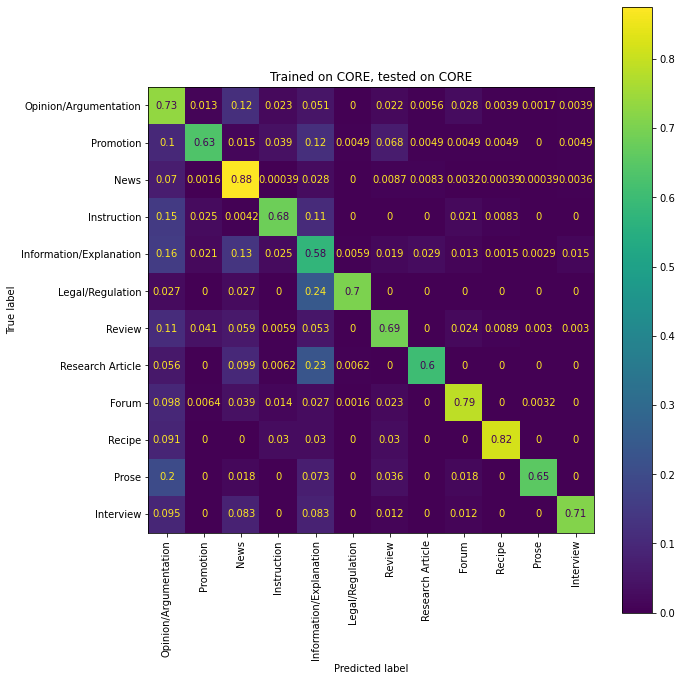

In [77]:
# Plot the confusion matrix:
# Choose the setup (take the index from the results_df table) 
setup = results[13]
trained_on = setup["trained_on"]
tested_on = setup["tested_on"]

y_true = setup["y_true"]
y_pred = setup["y_pred"]

# To display normalized values, leave normalize = "true", otherwise delete that
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels = LABELS, normalize = "true", xticks_rotation=90, cmap='plasma', colorbar=True, values_format=".1g")
#disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels = LABELS, xticks_rotation=90, cmap='plasma', colorbar=True, values_format=".1g")

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.xticks(np.arange(len(LABELS)), LABELS, rotation=90)
plt.title(f"Trained on {trained_on}, tested on {tested_on}")
plt.tight_layout()
fig1 = plt.gcf()
fig1.savefig(f"results-CroSloEngualBERT/Normalized confusion-matrix-{trained_on}-test-on-{tested_on}.png",dpi=100)
